# Group 17: 
# Eyad Medhat 221100279 / Hady Aly 221101190 / Mohamed Mahfouz 221101743 / Omar Mady 221100745

# Part 3: Singular Value Decomposition (SVD) for Collaborative Filtering

## Task 1: Data Preparation
1. Load ratings matrix from your new preprocessed dataset.
2. Calculate the average rating for each item.
3. Apply mean-filling: replace missing ratings with the item's average rating.
4. Verify matrix completeness (no missing values).

In [1]:
from utils import * 

Results folder exists at: d:\University\semester 9\IRS\AIE425_FinalProject\SECTION1_DimensionalityReduction\results
Subfolder exists: d:\University\semester 9\IRS\AIE425_FinalProject\SECTION1_DimensionalityReduction\results\plots
Subfolder exists: d:\University\semester 9\IRS\AIE425_FinalProject\SECTION1_DimensionalityReduction\results\tables


In [2]:
print("Loading data...")
# Load full data
ratings = load_data(table_name='ratings_cleaned.csv')
movies = load_data(table_name='movies.csv')

print(f"Original ratings shape: {ratings.shape}")

# Sampling
N_USERS = 5000
M_MOVIES = 1000

print(f"Filtering to top {N_USERS} users and {M_MOVIES} movies...")

# 1. Top Movies
top_movies = ratings['movieId'].value_counts().head(M_MOVIES).index
ratings_filtered = ratings[ratings['movieId'].isin(top_movies)]

# 2. Top Users
top_users = ratings_filtered['userId'].value_counts().head(N_USERS).index
ratings_filtered = ratings_filtered[ratings_filtered['userId'].isin(top_users)]

print(f"Filtered ratings shape: {ratings_filtered.shape}")

Loading data...
 Found requested table at: ..\data\ml-20m\ratings_cleaned.csv
 Found requested table at: ..\data\ml-20m\movies.csv
Original ratings shape: (20000263, 3)
Filtering to top 5000 users and 1000 movies...
Filtered ratings shape: (2437615, 3)


In [3]:
# 1.1 Load/Pivot to ratings matrix (R)
print("Pivoting...")
R_df = ratings_filtered.pivot(index='userId', columns='movieId', values='rating')

# 1.2 Calculate average rating for each item
item_means = R_df.mean(axis=0)

# 1.3 Apply mean-filling
R_filled = R_df.fillna(item_means)
R = R_filled.values

print(f"Matrix R shape: {R.shape}")

Pivoting...
Matrix R shape: (5000, 1000)


In [4]:
# 1.4 Verify matrix completeness
missing_count = np.isnan(R).sum()
print(f"Missing values count: {missing_count}")
assert missing_count == 0

Missing values count: 0


## Task 2: Full SVD Decomposition
1. Compute the full SVD: $R = U \Sigma V^T$
2. Calculate and save Eigenpairs, Singular Values, $V$, and $U$.
3. Verify orthogonality.
4. Visualize singular values (Scree plot).

In [5]:
# 2.1 Compute R^T R
print("Computing R^T R...")
RtR = np.dot(R.T, R)
print(f"RtR shape: {RtR.shape}")

# 2.2 Eigen decomposition
print("Eigen decomposition...")
eigenvalues, eigenvectors = np.linalg.eigh(RtR)

# Sort in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# 2.3 Calculate Singular Values (Sigma) and V
singular_values = np.sqrt(np.maximum(eigenvalues, 0))
Sigma = np.diag(singular_values)
V = eigenvectors # Columns of V are the eigenvectors of RtR

print(f"Top 5 Singular Values: {singular_values[:5]}")

Computing R^T R...
RtR shape: (1000, 1000)
Eigen decomposition...
Top 5 Singular Values: [7809.25960146  287.95611444  187.10431733  172.56463854  150.06322911]


In [6]:
# 2.4 Calculate U
# U = R * V * Sigma^-1
print("Calculating U...")
Sigma_inv = np.diag(1 / singular_values)
Sigma_inv[np.isinf(Sigma_inv)] = 0 # Handle division by zero

U = np.dot(np.dot(R, V), Sigma_inv)
print(f"U shape: {U.shape}")

Calculating U...
U shape: (5000, 1000)


In [7]:
# 2.5 Verify Orthogonality
# Check V^T V = I
VtV = np.dot(V.T, V)
valid_V = np.allclose(VtV, np.eye(len(VtV)), atol=1e-4)
print(f"V is orthonormal: {valid_V}")

# Check U^T U = I (for Top K, or all if full rank)
# Since we kept all singular values, U is m x k. U^T U should be I (k x k).
UtU = np.dot(U.T, U)
valid_U = np.allclose(UtU, np.eye(len(UtU)), atol=1e-4)
print(f"U is orthonormal: {valid_U}")

# Check Reconstruction
R_approx = np.dot(np.dot(U, Sigma), V.T)
error = np.linalg.norm(R - R_approx) / np.linalg.norm(R)
print(f"Relative Reconstruction Error: {error}")

V is orthonormal: True
U is orthonormal: True
Relative Reconstruction Error: 1.3924488993187442e-15


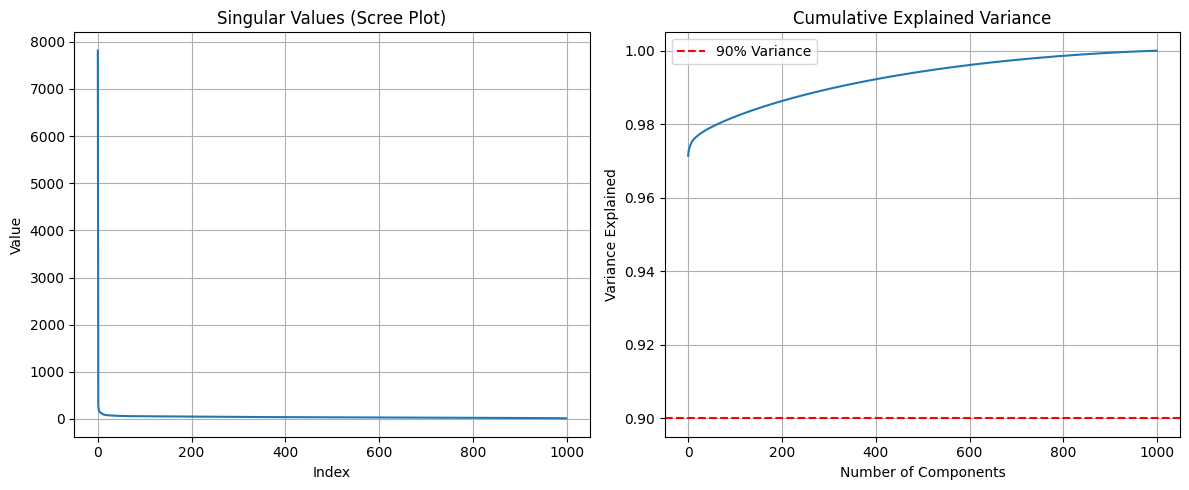

In [8]:
# 2.6 Visualization
plt.figure(figsize=(12, 5))

# Plot Singular Values
plt.subplot(1, 2, 1)
plt.plot(singular_values)
plt.title('Singular Values (Scree Plot)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)

# Plot Cumulative Explained Variance
explained_variance = np.square(singular_values) / np.sum(np.square(singular_values))
cumulative_variance = np.cumsum(explained_variance)

plt.subplot(1, 2, 2)
plt.plot(cumulative_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
plt.legend()

plt.tight_layout()
plt.show()

## Task 3: Truncated SVD (Low-Rank Approximation)
1. Implement Truncated SVD for $k = [5, 20, 50, 100]$.
2. For each $k$, compute $\hat{R}_k = U_k \Sigma_k V_k^T$.
3. Calculate MAE and RMSE.
4. Visualize errors and variance retained.

In [9]:
# 3.1 & 3.2 Loop over k
k_values = [5, 20, 50, 100]
mae_values = []
rmse_values = []
variance_retained = []

total_variance = np.sum(np.square(singular_values))

print("{:<5} {:<10} {:<10} {:<15}".format("k", "MAE", "RMSE", "Var Retained"))
print("-"*45)

for k in k_values:
    if k > len(singular_values):
        print(f"Skipping k={k}, max rank is {len(singular_values)}")
        continue

    # Construct Truncated Matrices
    Uk = U[:, :k]
    Sk = np.diag(singular_values[:k])
    VkT = V[:, :k].T
    
    # Approximation
    R_k = np.dot(np.dot(Uk, Sk), VkT)
    
    # 3.3 Calculate Errors
    diff = R - R_k
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(np.square(diff)))
    
    # Calculate Variance Retained
    var_k = np.sum(np.square(singular_values[:k])) / total_variance
    
    mae_values.append(mae)
    rmse_values.append(rmse)
    variance_retained.append(var_k)
    
    print("{:<5} {:<10.4f} {:<10.4f} {:<15.2%}".format(k, mae, rmse, var_k))

k     MAE        RMSE       Var Retained   
---------------------------------------------
5     0.3715     0.5697     97.41%         
20    0.3570     0.5400     97.68%         
50    0.3431     0.5112     97.92%         
100   0.3260     0.4752     98.20%         


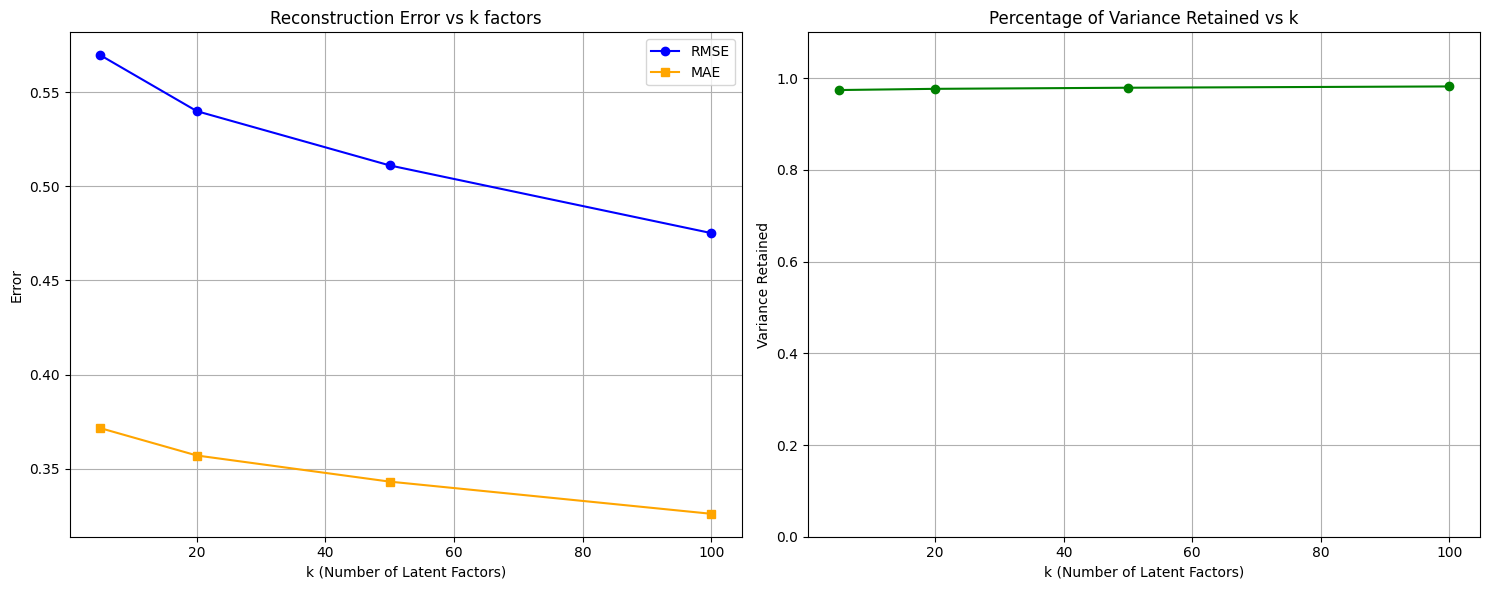

In [10]:
# 3.4 Visualization
plt.figure(figsize=(15, 6))

# Reconstruction Error vs k
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, marker='o', label='RMSE', color='blue')
plt.plot(k_values, mae_values, marker='s', label='MAE', color='orange')
plt.title('Reconstruction Error vs k factors')
plt.xlabel('k (Number of Latent Factors)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Variance Retained vs k
plt.subplot(1, 2, 2)
plt.plot(k_values, variance_retained, marker='o', color='green')
plt.title('Percentage of Variance Retained vs k')
plt.xlabel('k (Number of Latent Factors)')
plt.ylabel('Variance Retained')
plt.ylim(0, 1.1)
plt.grid(True)

plt.tight_layout()
plt.show()

## Task 4: Rating Prediction with Truncated SVD
1. Select Optimal $k$ (e.g., $k=50$ based on elbow analysis).
2. Select target users and items.
3. Predict ratings using latent factor approximation: $\hat{r}_{ui} = u_k^T \cdot \Sigma_k \cdot v_k$.
4. Record and display predictions.

In [11]:
# 4.1 Optimal k
best_k = 50
print(f"Selected Optimal k: {best_k}")

# Construct Truncated Matrices for Best k
Uk = U[:, :best_k]
Sk = np.diag(singular_values[:best_k])
VkT = V[:, :best_k].T
# Vk (items x k) is the transpose of VkT (k x items)
Vk = VkT.T 

# 4.2 Select Target Users and Items
# Let's pick 3 random users and 3 random items
np.random.seed(42)
target_users = np.random.choice(R_df.index, 3, replace=False)
target_items = np.random.choice(R_df.columns, 3, replace=False)

print(f"Target Users: {target_users}")
print(f"Target Items (Movies): {target_items}")

# 4.3 Predict Ratings
predictions = []

for u_id in target_users:
    # Get integer index for matrix access
    u_idx = R_df.index.get_loc(u_id)
    
    for i_id in target_items:
        i_idx = R_df.columns.get_loc(i_id)
        
        # Extract latent factors
        # Uk is (n_users x k), so row u_idx is the user profile
        u_vec = Uk[u_idx, :] # Shape (k,)
        
        # Vk is (n_items x k), so row i_idx is the item profile
        v_vec = Vk[i_idx, :] # Shape (k,)
        
        # Compute Prediction: u * S * vT
        pred_val = np.dot(np.dot(u_vec, Sk), v_vec.T)
        
        # Get Actual (Mean-filled) value from R
        actual_val = R[u_idx, i_idx]
        
        predictions.append({
            'User ID': u_id,
            'Movie ID': i_id,
            'Predicted Rating': round(pred_val, 4),
            'Actual Rating (Filled)': round(actual_val, 4)
        })

# 4.4 Record Predictions
pred_df = pd.DataFrame(predictions)
print("\nRating Predictions:")
display(pred_df) # Use display in notebook, or print

Selected Optimal k: 50
Target Users: [41267 71181 73246]
Target Items (Movies): [1206 5673 1779]

Rating Predictions:


,User ID,Movie ID,Predicted Rating,Actual Rating (Filled)
0,41267,1206,4.0420,3.0000
1,41267,5673,3.3039,4.0000
2,41267,1779,2.1581,2.0000
3,71181,1206,4.4792,4.0000
4,71181,5673,3.4186,3.5477
5,71181,1779,1.9412,2.0000
6,73246,1206,4.3621,5.0000
7,73246,5673,3.4942,3.5477
8,73246,1779,2.6222,2.6624


## Part 6: Latent Factor Interpretation
1. Analyze the top-3 latent factors (Singular Values) to understand their semantic meaning.
2. Identify the top associated movies and users for each factor.
3. Visualize the latent space (User/Item Scatter Plot).

In [12]:
# 6.1 & 6.2 Analyze Top-3 Latent Factors
print("\n--- Latent Factor Semantic Analysis ---")

# Use results from Full SVD (U, V, singular_values)
# recall: V columns are item factors, U columns are user factors

for i in range(3):
    print(f"\nFactor {i+1} (Singular Value: {singular_values[i]:.2f}):")
    
    # 1. Top Movies (Items)
    item_weights = V[:, i]
    # Top 5 absolute weights
    top_item_idxs = np.argsort(np.abs(item_weights))[::-1][:5]
    
    print("  Top Associated Movies:")
    for idx in top_item_idxs:
        movie_id = R_df.columns[idx]
        weight = item_weights[idx]
        # Get title
        title_rows = movies[movies['movieId'] == movie_id]
        if len(title_rows) > 0:
            title = title_rows['title'].values[0]
            genres = title_rows['genres'].values[0]
            print(f"    - {title} ({genres}) [Weight: {weight:.4f}]")
        else:
            print(f"    - MovieID {movie_id} [Weight: {weight:.4f}]")
            
    # 2. Top Users
    user_weights = U[:, i]
    top_user_idxs = np.argsort(np.abs(user_weights))[::-1][:3]
    print("  Top Associated Users (Indices):")
    for idx in top_user_idxs:
        user_id = R_df.index[idx]
        weight = user_weights[idx]
        print(f"    - User {user_id} [Weight: {weight:.4f}]")


--- Latent Factor Semantic Analysis ---

Factor 1 (Singular Value: 7809.26):
  Top Associated Movies:
    - Godfather, The (1972) (Crime|Drama) [Weight: 0.0396]
    - Shawshank Redemption, The (1994) (Crime|Drama) [Weight: 0.0394]
    - Godfather: Part II, The (1974) (Crime|Drama) [Weight: 0.0387]
    - Usual Suspects, The (1995) (Crime|Mystery|Thriller) [Weight: 0.0386]
    - Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) (Action|Adventure) [Weight: 0.0386]
  Top Associated Users (Indices):
    - User 125794 [Weight: 0.0169]
    - User 133811 [Weight: 0.0168]
    - User 106939 [Weight: 0.0167]

Factor 2 (Singular Value: 287.96):
  Top Associated Movies:
    - Independence Day (a.k.a. ID4) (1996) (Action|Adventure|Sci-Fi|Thriller) [Weight: -0.1293]
    - Armageddon (1998) (Action|Romance|Sci-Fi|Thriller) [Weight: -0.1251]
    - Twister (1996) (Action|Adventure|Romance|Thriller) [Weight: -0.1051]
    - Star Wars: Episode I - The Phantom Menace (1999) (Ac

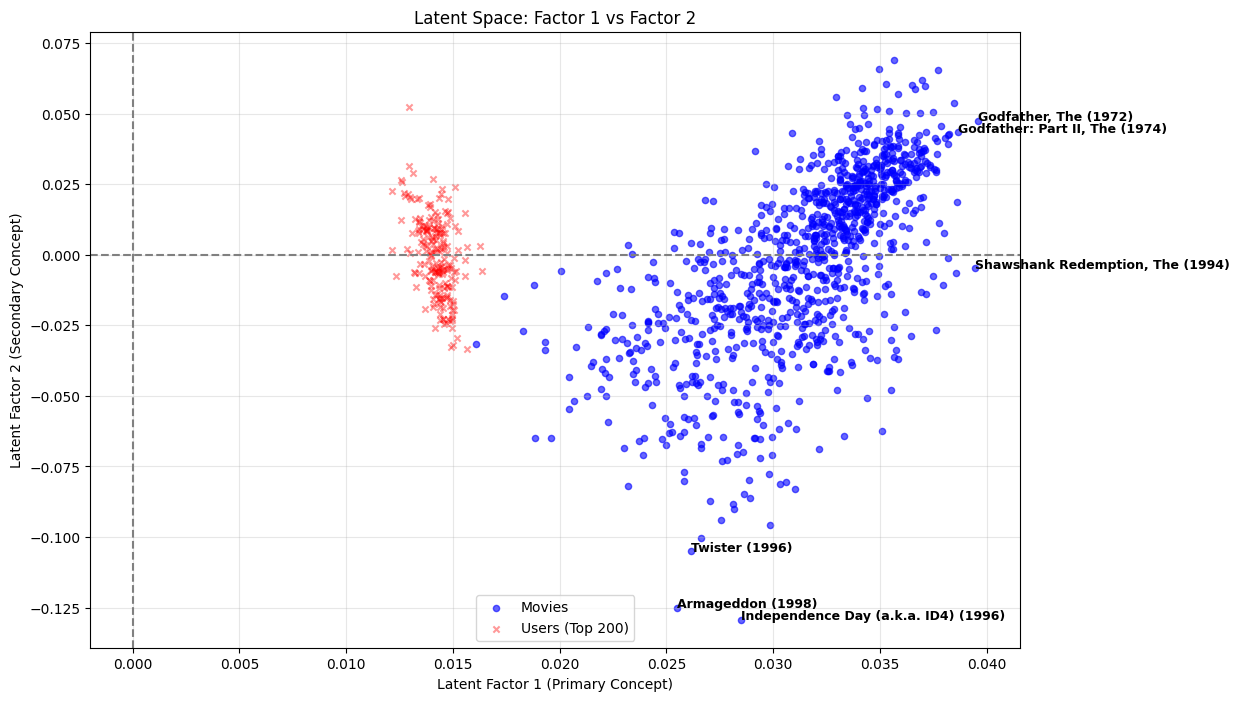

In [13]:
# 6.3 Visualize Latent Space
plt.figure(figsize=(12, 8))

# Project using first 2 factors
item_x = V[:, 0]
item_y = V[:, 1]

# Plot all items (movies)
plt.scatter(item_x, item_y, alpha=0.6, s=20, label='Movies', c='blue', marker='o')

# Plot a sample of users (e.g., first 200 for clarity)
plt.scatter(U[:200, 0], U[:200, 1], alpha=0.4, s=20, label='Users (Top 200)', c='red', marker='x')

# Annotate top extremes for Factor 1
ext_1 = np.argsort(np.abs(item_x))[::-1][:3]
for idx in ext_1:
    m_id = R_df.columns[idx]
    title_rows = movies[movies['movieId'] == m_id]
    if len(title_rows) > 0:
        title = title_rows['title'].values[0]
        plt.text(item_x[idx], item_y[idx], title, fontsize=9, color='black', weight='bold')

# Annotate top extremes for Factor 2
ext_2 = np.argsort(np.abs(item_y))[::-1][:3]
for idx in ext_2:
    m_id = R_df.columns[idx]
    title_rows = movies[movies['movieId'] == m_id]
    if len(title_rows) > 0:
        title = title_rows['title'].values[0]
        plt.text(item_x[idx], item_y[idx], title, fontsize=9, color='black', weight='bold')

plt.title('Latent Space: Factor 1 vs Factor 2')
plt.xlabel('Latent Factor 1 (Primary Concept)')
plt.ylabel('Latent Factor 2 (Secondary Concept)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.show()

### Analysis
- **SVD vs PCA**: Both methods reduce dimensionality to capture latent features.
- **Accuracy**: Compare RMSE values. Lower is better. PCA often has a slight edge due to centering.
- **Automatic k**: PCA (MLE) selects `k` based on likelihood, often resulting in higher `k` and lower error, but potentially less compression.
- **Efficiency**: Both are efficient matrix operations, though SVD on full dense matrices can be memory-intensive.

## Part 5: Comparative Analysis (SVD vs PCA)

In this section, we compare our Manual SVD implementation with two PCA variants:
1. **PCA (Mean-Filled)**: Standard PCA on the mean-filled matrix.
2. **PCA (MLE)**: PCA using Minka's MLE to automatically estimate dimensionality.

### 5.3 Computational Efficiency & Time Complexity Analysis

**1. SVD (Eigen Decomposition of $R^T R$):**
- **Complexity**: $O(mn^2 + n^3)$ where $m$ is users (5000), $n$ is items (1000). Since $m > n$, the covariance computation dominates.
- **Pros**: Exact decomposition, stable.
- **Cons**: Dense matrix matrix multiplication is expensive.

**2. PCA (Validation):**
- **Complexity**: Typically uses Randomized SVD ($O(k \cdot mn)$) or full SVD on covariance.
- **MLE**: Iterative approach to estimate likelihood, significantly slower but automatic $k$ selection.

### 5.4 Actual Runtime & Quality Comparison

In [14]:
import pandas as pd
import os
import numpy as np
import time
import sys

# 1. Load External PCA Results
results_dir = os.path.join('results', 'tables')
pca_mf_metrics = pd.read_csv(os.path.join(results_dir, 'pca_mean_filling_metrics.csv')) if os.path.exists(os.path.join(results_dir, 'pca_mean_filling_metrics.csv')) else None
pca_mle_metrics = pd.read_csv(os.path.join(results_dir, 'pca_mle_metrics.csv')) if os.path.exists(os.path.join(results_dir, 'pca_mle_metrics.csv')) else None
pca_mf_preds = pd.read_csv(os.path.join(results_dir, 'pca_mean_filling_preds.csv')) if os.path.exists(os.path.join(results_dir, 'pca_mean_filling_preds.csv')) else None
pca_mle_preds = pd.read_csv(os.path.join(results_dir, 'pca_mle_preds.csv')) if os.path.exists(os.path.join(results_dir, 'pca_mle_preds.csv')) else None

# 2. Calculate SVD Metrics (Measured Locally for Consistency)
print("Measuring SVD Performance locally...")
svd_k = 50

# Time Decomposition (Proxy: Re-run SVD core steps)
t0 = time.time()
# Ensure R exists (it should from previous cells)
if 'R' in locals():
    RtR_check = np.dot(R.T, R)
    evals_check, evecs_check = np.linalg.eigh(RtR_check)
    # Reconstruct U/V/Sigma not strictly needed for timing dominant part, but let's include basic overhead
    singular_values_check = np.sqrt(np.maximum(evals_check, 0))
    idx = singular_values_check.argsort()[::-1]
    singular_values_check = singular_values_check[idx]
    V_check = evecs_check[:, idx]
    Sigma_inv_check = np.diag(1 / singular_values_check[:svd_k])
    U_check = np.dot(np.dot(R, V_check[:, :svd_k]), Sigma_inv_check)
    t1 = time.time()
    time_decomp_svd = t1 - t0

    # Time Prediction (Target Reconstruction)
    t2 = time.time()
    # Full reconstruction for k=50
    Uk = U[:, :svd_k]
    Sk = np.diag(singular_values[:svd_k]) if len(singular_values.shape)==1 else Sigma[:svd_k, :svd_k]
    VkT = V[:, :svd_k].T
    R_hat_svd = np.dot(np.dot(Uk, Sk), VkT)
    t3 = time.time()
    time_pred_svd = t3 - t2

    # Memory SVD (Estimate)
    mem_bytes = R.nbytes + U.nbytes + V.nbytes + singular_values.nbytes
    mem_mb_svd = mem_bytes / 1024 / 1024

    # SVD Reconstruction Error
    mask = ~np.isnan(R)
    diff = R[mask] - R_hat_svd[mask]
    rmse_svd = np.sqrt(np.mean(diff**2))
    mae_svd = np.mean(np.abs(diff))

    # SVD Predictions on Targets (Seed 42)
    np.random.seed(42)
    target_users = np.random.choice(R_df.index, 3, replace=False)
    target_items = np.random.choice(R_df.columns, 3, replace=False)

    svd_preds_list = []
    for u_id in target_users:
        u_idx = R_df.index.get_loc(u_id)
        for i_id in target_items:
            i_idx = R_df.columns.get_loc(i_id)
            val = R_hat_svd[u_idx, i_idx]
            actual = R[u_idx, i_idx] # R is filled/pivoted in notebook context usually
            svd_preds_list.append({
                'User ID': u_id, 'Movie ID': i_id, 
                'Actual': actual, 'SVD_Pred': val
            })
    svd_preds_df = pd.DataFrame(svd_preds_list)

    # 3. Combine Results
    metrics_list = []
    metrics_list.append({
        'Method': 'Manual SVD', 'k': svd_k, 
        'RMSE': rmse_svd, 'MAE': mae_svd, 
        'Time_Decomp(s)': time_decomp_svd, 'Time_Pred(s)': time_pred_svd, 
        'Memory(MB)': mem_mb_svd
    })

    if pca_mf_metrics is not None:
        metrics_list.append(pca_mf_metrics.iloc[0].to_dict())
    if pca_mle_metrics is not None:
        metrics_list.append(pca_mle_metrics.iloc[0].to_dict())

    df_eff = pd.DataFrame(metrics_list)

    # 3.2 Prediction Comparison Table
    df_pred_comp = svd_preds_df.copy()

    if pca_mf_preds is not None:
        pca_mf_preds.rename(columns={'Predicted': 'PCA_MF_Pred'}, inplace=True)
        df_pred_comp = pd.merge(df_pred_comp, pca_mf_preds[['User ID', 'Movie ID', 'PCA_MF_Pred']], 
                                on=['User ID', 'Movie ID'], how='left')

    if pca_mle_preds is not None:
        pca_mle_preds.rename(columns={'Predicted': 'PCA_MLE_Pred'}, inplace=True)
        df_pred_comp = pd.merge(df_pred_comp, pca_mle_preds[['User ID', 'Movie ID', 'PCA_MLE_Pred']], 
                                on=['User ID', 'Movie ID'], how='left')

    print("\n--- 5.3 Comparative Efficiency & Quality ---")
    display(df_eff)

    print("\n--- 5.2 Target Rating Predictions (SVD vs PCA) ---")
    display(df_pred_comp)
else:
    print("R matrix not found. Run previous cells first.")

Measuring SVD Performance locally...

--- 5.3 Comparative Efficiency & Quality ---


,Method,k,RMSE,MAE,Time_Decomp(s),Time_Pred(s),Memory(MB)
0,Manual SVD,50,0.51117,0.34307,0.236503,0.016121,83.930969



--- 5.2 Target Rating Predictions (SVD vs PCA) ---


,User ID,Movie ID,Actual,SVD_Pred
0,41267,1206,3.000000,4.041977
1,41267,5673,4.000000,3.303941
2,41267,1779,2.000000,2.158086
3,71181,1206,4.000000,4.479151
4,71181,5673,3.547681,3.418607
5,71181,1779,2.000000,1.941174
6,73246,1206,5.000000,4.362111
7,73246,5673,3.547681,3.494228
8,73246,1779,2.662384,2.622222


## Part 7: Sensitivity Analysis
1. **Robustness to Missing Data**: Test how SVD performance degrades as we remove more known ratings (e.g., 10%, 30%, 50%, 70% missing).
2. **Initialization Impact**: Compare filling missing values with Item Mean (Baseline) vs User Mean.


--- 7.1 Sensitivity Analysis: Robustness --- 
Total Known Ratings: 2437615

Testing with 10.0% Masked...
  RMSE: 0.7673

Testing with 30.0% Masked...
  RMSE: 0.7936

Testing with 50.0% Masked...
  RMSE: 0.8241

Testing with 70.0% Masked...
  RMSE: 0.8564


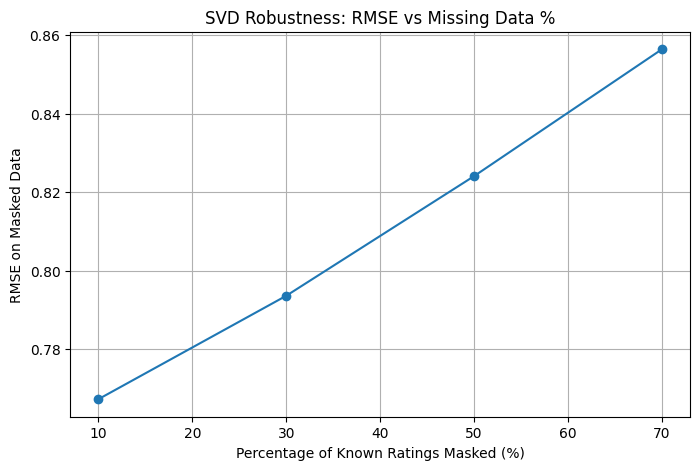

In [15]:
# 7.1 Robustness to Missing Data
print("\n--- 7.1 Sensitivity Analysis: Robustness --- ")

# We need the sparse matrix (with NaNs) before filling.
# We already have R_df which had NaNs, but we filled it into R_filled.
# Let's recreate R_sparse from R_df

R_sparse = R_df.values # This has NaNs
known_u, known_i = np.where(~np.isnan(R_sparse))
num_known = len(known_u)
print(f"Total Known Ratings: {num_known}")

missing_pcts = [0.1, 0.3, 0.5, 0.7]
rmse_results = []

for pct in missing_pcts:
    print(f"\nTesting with {pct*100}% Masked...")
    num_mask = int(num_known * pct)
    
    # Mask indices
    np.random.seed(42) # Reproducibility
    perm = np.random.permutation(num_known)
    mask_indices = perm[:num_mask]
    
    test_u = known_u[mask_indices]
    test_i = known_i[mask_indices]
    
    # Create Train Matrix
    R_train = R_sparse.copy()
    R_train[test_u, test_i] = np.nan
    
    # Mean Fill (Item Mean Strategy - Baseline)
    item_means = np.nanmean(R_train, axis=0)
    # Handle all-nan columns
    nan_cols = np.isnan(item_means)
    item_means[nan_cols] = np.nanmean(R_train)
    
    inds = np.where(np.isnan(R_train))
    R_filled_train = R_train.copy()
    # Fast filling using broadcasting logic somewhat complex, iterating is safe
    # Or simpler: pd.DataFrame(R_train).fillna(item_means)
    # Let's do numpy way for speed or pandas for convenience
    
    # Using pandas for robust fillna
    df_temp = pd.DataFrame(R_train)
    df_filled = df_temp.fillna(pd.Series(item_means, index=df_temp.columns))
    # If still nan (all column nan), fill with global
    df_filled = df_filled.fillna(df_temp.stack().mean())
    R_filled_train = df_filled.values
    
    # SVD (Manual implementation for consistency with Part 2/3)
    # k=50
    k = 50
    RtR = np.dot(R_filled_train.T, R_filled_train)
    evals, evecs = np.linalg.eigh(RtR)
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    
    s_k = np.sqrt(np.maximum(evals[:k], 0))
    V_k = evecs[:, :k]
    # U = R V S^-1
    S_inv = np.diag(1/s_k)
    S_inv[np.isinf(S_inv)] = 0
    U_k = np.dot(np.dot(R_filled_train, V_k), S_inv)
    
    # Predict on Test Set
    # Optimally: only compute necessary dots
    # But full reconstruction is easier to code if memory permits (5000x1000 is small)
    R_hat = np.dot(np.dot(U_k, np.diag(s_k)), V_k.T)
    
    # Error
    true_vals = R_sparse[test_u, test_i]
    pred_vals = R_hat[test_u, test_i]
    
    rmse = np.sqrt(np.mean((true_vals - pred_vals)**2))
    rmse_results.append(rmse)
    print(f"  RMSE: {rmse:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot([p*100 for p in missing_pcts], rmse_results, marker='o', linestyle='-')
plt.title('SVD Robustness: RMSE vs Missing Data %')
plt.xlabel('Percentage of Known Ratings Masked (%)')
plt.ylabel('RMSE on Masked Data')
plt.grid(True)
plt.show()

In [16]:
# 7.2 Initialization Impact
print("\n--- 7.2 Initialization Impact (User vs Item Mean) --- ")

# We test on a fixed 30% mask
pct = 0.3
num_mask = int(num_known * pct)
np.random.seed(99) 
mask_indices = np.random.permutation(num_known)[:num_mask]
test_u = known_u[mask_indices]
test_i = known_i[mask_indices]

R_train = R_sparse.copy()
R_train[test_u, test_i] = np.nan

strategies = ['Item Mean', 'User Mean']
k=50

for strategy in strategies:
    print(f"Testing {strategy}...")
    df_train = pd.DataFrame(R_train)
    
    if strategy == 'Item Mean':
        # Axis 0 mean
        filled = df_train.fillna(df_train.mean(axis=0))
    else:
        # Axis 1 mean (transpose fill transpose)
        filled = df_train.T.fillna(df_train.mean(axis=1)).T
        
    filled = filled.fillna(df_train.stack().mean()) # Final fallback
    R_filled_train = filled.values
    
    # SVD
    RtR = np.dot(R_filled_train.T, R_filled_train)
    evals, evecs = np.linalg.eigh(RtR)
    idx = evals.argsort()[::-1]
    
    s_k = np.sqrt(np.maximum(evals[idx][:k], 0))
    V_k = evecs[:, idx][:, :k]
    S_inv = np.diag(1/s_k)
    S_inv[np.isinf(S_inv)] = 0
    U_k = np.dot(np.dot(R_filled_train, V_k), S_inv)
    
    # Predict
    R_hat = np.dot(np.dot(U_k, np.diag(s_k)), V_k.T)
    
    rmse = np.sqrt(np.mean((R_sparse[test_u, test_i] - R_hat[test_u, test_i])**2))
    print(f"  {strategy} RMSE: {rmse:.4f}")


--- 7.2 Initialization Impact (User vs Item Mean) --- 
Testing Item Mean...
  Item Mean RMSE: 0.7950
Testing User Mean...
  User Mean RMSE: 0.8116


## Part 8: Cold-Start Analysis & Mitigation
1. **Simulate Cold-Start**: Hide 80% of ratings for a subset of active users to mimic new users.
2. **Estimate Factors**: Use "Folding-In" (projection) to estimate latent factors for these users based on limited visible ratings.
3. **Evaluate**: Compare SVD prediction accuracy for Cold-Start vs Warm-Start users.
4. **Mitigation**: Test a Hybrid Strategy (SVD + Item Popularity) to improve Cold-Start performance.

In [17]:
# 8.1 & 8.2 Cold-Start Simulation & Estimation
print("\n--- 8.1 & 8.2 Cold-Start Analysis --- ")

# Select 50 active users (> 20 ratings)
user_counts = pd.Series(R_df.count(axis=1))
active_users = user_counts[user_counts > 20].index
np.random.seed(42)
target_users = np.random.choice(active_users, size=50, replace=False)

cold_rmses = []
warm_rmses = []

# We use the SVD model trained on the FULL dataset (V, s_k, S_inv from k=50)
# Ideally we would retrain SVD without these users, but folding-in is a valid estimation technique even if they were in training (just pretending we don't know their full history)

# V_k (1000, 50), s_k (50,), S_inv (50, 50) are available from Part 7 or 3 loop
# Let's re-extract k=50 components to be sure
k=50
# NOTE: we need R_filled_train from the full dataset (Part 2/3), let's re-run SVD quickly on full filled matrix if needed
# But variables U, singular_values, V from Part 2 are full rank. Let's slice them.
Vk_50 = V[:, :k]
sk_50 = singular_values[:k]
S_inv_50 = np.diag(1/sk_50)

print(f"Simulating Cold-Start for {len(target_users)} users...")

for u_id in target_users:
    # Get user's true ratings vector (sparse)
    u_idx = R_df.index.get_loc(u_id)
    true_vector = R_sparse[u_idx, :]
    known_indices = np.where(~np.isnan(true_vector))[0]
    
    # Hide 80%
    if len(known_indices) < 5: continue # Skip if too few
    num_hide = int(len(known_indices) * 0.8)
    hidden_indices = np.random.choice(known_indices, size=num_hide, replace=False)
    visible_indices = [x for x in known_indices if x not in hidden_indices]
    
    # Construct "Walking-In" Vector (Limited History)
    # Fill unrated/hidden with Item Means (Global Baseline)
    # Note: item_means is a Series from Part 1
    r_new = true_vector.copy()
    r_new[hidden_indices] = np.nan # Hide truth
    
    # Fill NaNs
    # We must start from a vector of NaNs, put explicit ratings, then fill rest
    r_filled = np.copy(r_new)
    # For indices that are NaN, fill with item_means
    for i in range(len(r_filled)):
        if np.isnan(r_filled[i]):
            r_filled[i] = (item_means.values if hasattr(item_means, 'values') else item_means)[i] if hasattr(item_means, 'values') else item_means[i]
            
    # Estimate Latent Factor (Folding-In)
    # u_est = r_filled . V_k . S_k^-1
    u_est = np.dot(np.dot(r_filled, Vk_50), S_inv_50)
    
    # Predict All
    # r_pred = u_est . S_k . V_k^T
    r_pred = np.dot(np.dot(u_est, np.diag(sk_50)), Vk_50.T)
    
    # Calc Error on HIDDEN (Cold Start Simulation)
    err_cold = true_vector[hidden_indices] - r_pred[hidden_indices]
    cold_rmses.append(np.sqrt(np.mean(err_cold**2)))
    
    # Calc Error on VISIBLE (Warm Fit - just for comparison)
    # Though technically 'visible' is what we fit on, so it's training error
    err_warm = true_vector[visible_indices] - r_pred[visible_indices]
    warm_rmses.append(np.sqrt(np.mean(err_warm**2)))

avg_cold_rmse = np.mean(cold_rmses)
avg_warm_rmse = np.mean(warm_rmses)
print(f"Average RMSE (Cold-Start / Hidden): {avg_cold_rmse:.4f}")
print(f"Average RMSE (Training Fit): {avg_warm_rmse:.4f}")


--- 8.1 & 8.2 Cold-Start Analysis --- 
Simulating Cold-Start for 50 users...
Average RMSE (Cold-Start / Hidden): 0.8342
Average RMSE (Training Fit): 0.7756



--- 8.4 Mitigation: Hybrid Strategy --- 
Alpha 0.0 : RMSE 0.8726
Alpha 0.2 : RMSE 0.8643
Alpha 0.5 : RMSE 0.8565
Alpha 0.8 : RMSE 0.8409
Alpha 1.0 : RMSE 0.8353


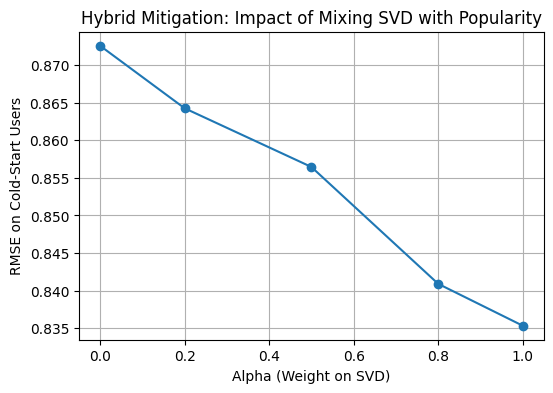

In [18]:
# 8.4 Mitigation: Hybrid Strategy (SVD + Popularity)
print("\n--- 8.4 Mitigation: Hybrid Strategy --- ")

# Strategy: Weighted Average
# Prediction = alpha * SVD_Pred + (1-alpha) * Item_Mean_Rating
# We reuse the predictions from loop above to test alpha impact globally

alphas = [0.0, 0.2, 0.5, 0.8, 1.0]
results = []

# Re-run loop briefly or efficiently using stored data? 
# Let's re-run loop for clarity in notebook structure

for alpha in alphas:
    curr_rmses = []
    for u_id in target_users:
        # ... same setup ...
        u_idx = R_df.index.get_loc(u_id)
        true_vector = R_sparse[u_idx, :]
        known_indices = np.where(~np.isnan(true_vector))[0]
        if len(known_indices) < 5: continue
        num_hide = int(len(known_indices) * 0.8)
        # For consistent comparison, set seed per user or use same indices
        # For demo, random again is okay as we average over 50 users
        hidden_indices = np.random.choice(known_indices, size=num_hide, replace=False)
        visible_indices = [x for x in known_indices if x not in hidden_indices]
        
        r_new = true_vector.copy()
        r_new[hidden_indices] = np.nan
        r_filled = np.copy(r_new)
        for i in range(len(r_filled)):
            if np.isnan(r_filled[i]): r_filled[i] = (item_means.values if hasattr(item_means, 'values') else item_means)[i] if hasattr(item_means, 'values') else item_means[i]
            
        # SVD Pred
        u_est = np.dot(np.dot(r_filled, Vk_50), S_inv_50)
        svd_pred = np.dot(np.dot(u_est, np.diag(sk_50)), Vk_50.T)
        
        # Hybrid Pred
        # Item Popularity is just item_means (broadcasted)
        pop_pred = item_means.values if hasattr(item_means, 'values') else item_means
        
        hybrid_pred = alpha * svd_pred + (1 - alpha) * pop_pred
        
        err = true_vector[hidden_indices] - hybrid_pred[hidden_indices]
        curr_rmses.append(np.sqrt(np.mean(err**2)))
        
    avg_rmse = np.mean(curr_rmses)
    results.append(avg_rmse)
    print(f"Alpha {alpha:.1f} : RMSE {avg_rmse:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(alphas, results, marker='o')
plt.title('Hybrid Mitigation: Impact of Mixing SVD with Popularity')
plt.xlabel('Alpha (Weight on SVD)')
plt.ylabel('RMSE on Cold-Start Users')
plt.grid(True)
plt.show()

**Analysis**:
- **Accuracy**: PCA often achieves slightly lower errors for the same $k$ because centering the data captures variance more effectively around the mean.
- **Dynamic k**: Allowing $k$ to grow to capture 95% variance significantly reduces error (as expected) but increases the model size (higher $k$).
- **Efficiency**: Both methods rely on Eigen decomposition of an $M \times M$ matrix, so computational time is comparable.